In [6]:
# extracting from drive ---------------------------------------------------------
# region
# @title  Colab_specific { display-mode: "form" }


from google.colab import drive
drive.mount('/content/gdrive')

import zipfile
import os
extract_source = "/content/gdrive/My Drive/GUC Bachelor : Arabic Image-to-Letters Script Recognition/data set/data set 2.zip"
extract_destination = "/content/extracted_from_drive"
zip_ref = zipfile.ZipFile(extract_source, 'r')
print("extracting...")
zip_ref.extractall(extract_destination)
extracted_folder_name = os.listdir(extract_destination)[0]
zip_ref.close()
print("extracted files from drive to colab successfully !")
all_entities_path = os.path.join(extract_destination, extracted_folder_name)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
extracting...
extracted files from drive to colab successfully !


In [8]:

# checking corrupted files ---------------------------------------------------------
# region
# @title Checking corrupted files { display-mode: "form" }
import os
import uuid
from PIL import Image
import warnings

# ----------------------------------------------------------------------------------------------------
# all_entities_path = './data set 2/' uncomment if working on local machine
all_entities_names = os.listdir(all_entities_path)
# ----------------------------------------------------------------------------------------------------
data_is_corrupted = False
print("\nVerifying all files are non-corrupted images...")
for entity_name in all_entities_names:
    entity_path = os.path.join(all_entities_path, entity_name)
    for filename in os.listdir(entity_path):
        file_path = os.path.join(entity_path, filename)
        try:
            with warnings.catch_warnings():
                warnings.simplefilter('error')  # treat warnings as exceptions within this context
                img = Image.open(file_path)
                img.verify()
        except (IOError, SyntaxError, UserWarning) as e:  # catch UserWarning along with other exceptions
            print(type(e) , "for file", filename, ":", e)
            data_is_corrupted = True
            os.remove(file_path)  # delete the file
            print(f"file {filename} in folder {entity_name} is corrupted and has been deleted")
print("your data is ok." if not data_is_corrupted else "done reporting error files.")



Verifying all files are non-corrupted images...
your data is ok.


In [9]:

# extracting from drive ---------------------------------------------------------
# region
# @title Renaming { display-mode: "form" }

# ----------------------------------------------------------------------------------------------------
# First pass to rename all files to a temporary unique name to avoid renaming a file with a name that belongs to another file in the same folder
print("giving temporary unique names...")
for entity_name in all_entities_names:
    entity_path = os.path.join(all_entities_path, entity_name)
    for filename in os.listdir(entity_path):
        temp_filename = str(uuid.uuid4()) + ".jpg"  # generate a unique filename
        source = os.path.join(entity_path, filename)
        destination = os.path.join(entity_path, temp_filename)
        os.rename(source, destination)
# ----------------------------------------------------------------------------------------------------
print("renaming...")
# then rename every file in every folder in the given path

for entity_name in all_entities_names:
    entity_path = os.path.join(all_entities_path, entity_name)
    i = 1
    for filename in os.listdir(entity_path):
        entity_name = entity_name.lower()
        new_filename = entity_name + '.' + str(i) + ".jpg"
        source = os.path.join(entity_path, filename)
        destination = os.path.join(entity_path, new_filename)
        os.rename(source, destination)
        i += 1

print("done")




giving temporary unique names...
renaming...
done


In [10]:
# 0 ---------------------------------------------------------imports
# region

# @title 0 - imports { display-mode: "form" }
import os
import random
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

# test if the GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus if gpus else "No GPU available, using CPU instead.")

# endregion



No GPU available, using CPU instead.


In [11]:
# 1 ---------------------------------------------------------Loading Images in a Dataframe
# region
# @title 1 - Loading Images in a Dataframe { display-mode: "form" }

# all_entities_path = "../dogs-vs-cats/data set 2/" # uncomment this if running on local machine
all_entities_names = os.listdir(all_entities_path)

filenames = []
percentage = 1  # Use only a percentage of the data to speed up the process
for entity_name in all_entities_names:
    entity_path = os.path.join(all_entities_path, entity_name)
    entity_filenames = os.listdir(entity_path)
    random.shuffle(entity_filenames)
    entity_filenames = entity_filenames[:int(len(entity_filenames) * percentage)]
    filenames.extend([os.path.join(entity_name, file_name) for file_name in entity_filenames])
file_labels = [x.split(os.sep)[0] for x in filenames]
data = pd.DataFrame({"filename": filenames, "label": file_labels})
# endregion


In [12]:
# 2 --------------------------------------------------------- Train Test Split
# region
# @title 2 - Train Test Split { display-mode: "form" }

all_entities_names = data['label']
X_train, X_temp = train_test_split(data, test_size=0.2, stratify=all_entities_names, random_state = 42)
label_test_val = X_temp['label']
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print(" ")
print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)
print(" ")

# endregion


 
The shape of train data (19997, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)
 


In [13]:
# 3 --------------------------------------------------------- Data Preparation
# region
# @title 3 - Data Preparation { display-mode: "form" }

image_size = 128
image_channel = 3
bat_size = 32

# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                directory = all_entities_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                class_mode='categorical')
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                directory = all_entities_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                shuffle=False,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                directory = all_entities_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                shuffle=False,
                                                class_mode='categorical')

# endregion



Found 19997 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [14]:
# 4 --------------------------------------------------------- Deep Learning Model
# region
# @title 4 - Deep Learning Model { display-mode: "form" }

model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Bloack 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax'))
# model.summary()

# endregion



In [15]:
# 4 --------------------------------------------------------- Deep Learning Model
# region
# @title 4 - Deep Learning Model { display-mode: "form" }

model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Bloack 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax'))
# model.summary()

# endregion



In [16]:
# 5 --------------------------------------------------------- Callbacks
# region
# @title 5 - Callbacks { display-mode: "form" }
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

# endregion

#

In [17]:
# 6 --------------------------------------------------------- Model Compilation
# region
# @title 6 - Model Compilation { display-mode: "form" }
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

# endregion

#

In [18]:
# 7 --------------------------------------------------------- Model Fitting
# region
# @title 7 - Model Fitting { display-mode: "form" }

print("x_train length: ",len(X_train))
print("x_test length: ",len(X_test))
print("batch size: ",bat_size)
print("steps_per_epoch: ",len(X_train) , " // " , bat_size , " = " , len(X_train) // bat_size)
print("validation_steps: ",len(X_test) , " // " , bat_size , " = " , len(X_test) // bat_size)
cat_dog = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks=[early_stoping,learning_rate_reduction],
                    epochs = 30,
                    # data generator must generate at least steps_per_epochs * epochs batches

                    steps_per_epoch = len(X_train) // bat_size,
                    validation_steps = len(X_test) // bat_size,
                   )

# endregion

#

x_train length:  19997
x_test length:  2500
batch size:  32
steps_per_epoch:  19997  //  32  =  624
validation_steps:  2500  //  32  =  78
Epoch 1/30
624/624 [==============================] - 1229s 2s/step - loss: 0.6840 - accuracy: 0.6649 - val_loss: 0.7208 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 2/30
624/624 [==============================] - 1221s 2s/step - loss: 0.5117 - accuracy: 0.7512 - val_loss: 0.6312 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 3/30
624/624 [==============================] - 1215s 2s/step - loss: 0.4450 - accuracy: 0.7927 - val_loss: 0.4967 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 4/30
624/624 [==============================] - 1216s 2s/step - loss: 0.3928 - accuracy: 0.8214 - val_loss: 0.9280 - val_accuracy: 0.6859 - lr: 0.0010
Epoch 5/30
624/624 [==============================] - 1200s 2s/step - loss: 0.3545 - accuracy: 0.8429 - val_loss: 0.3129 - val_accuracy: 0.8610 - lr: 0.0010
Epoch 6/30
624/624 [==============================] - 1200s 2s/step - loss: 

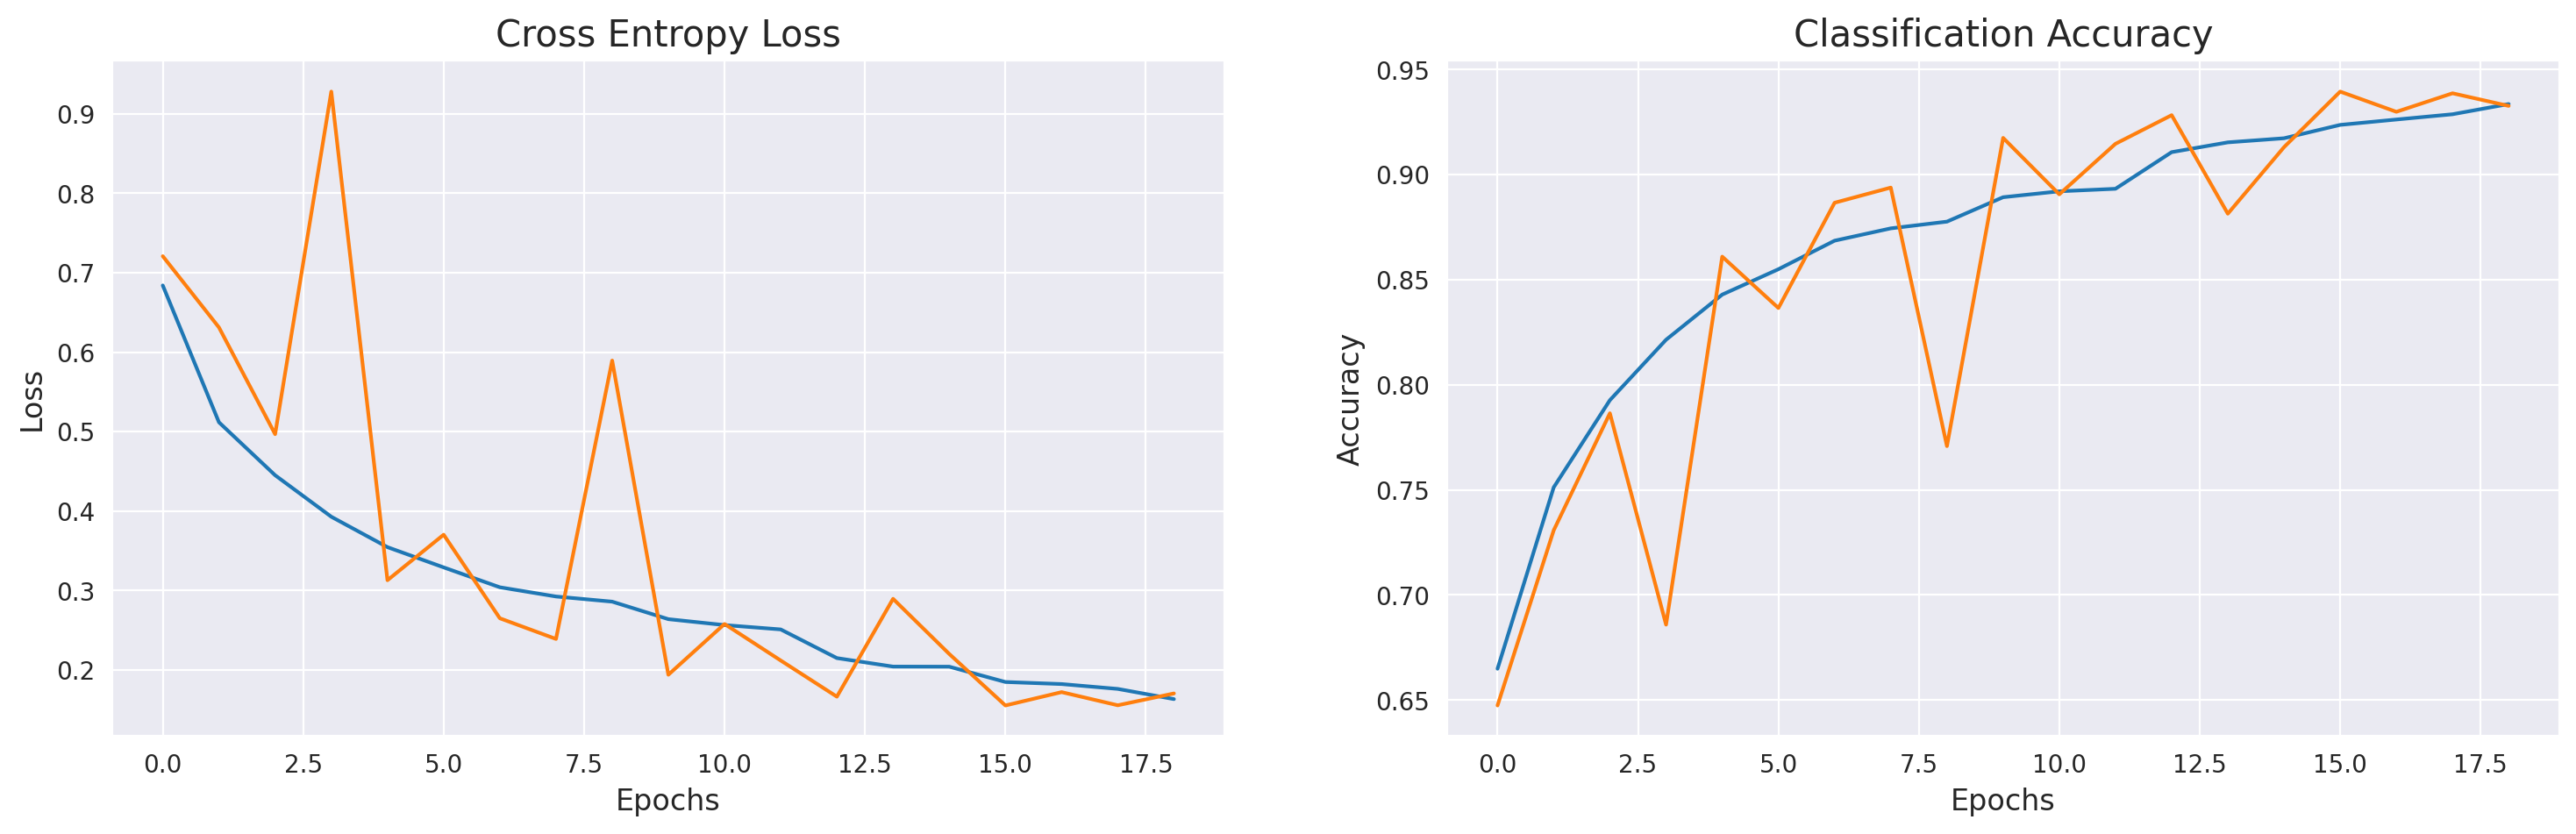

In [19]:
# 8 --------------------------------------------------------- Plot the results
# region
# @title 8 - Plot the results { display-mode: "form" }
# plots for accuracy and Loss with epochs

error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show(block=False)  # hosain : prevent the popup


# endregion

#

In [20]:
# 9 --------------------------------------------------------- Evaluation
# region
# @title 9 - Evaluation { display-mode: "form" }
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

#  endregion

#

The accuracy of the model for training data is: 94.83922719955444
The Loss of the model for training data is: 0.13372814655303955
The accuracy of the model for validation data is: 93.95999908447266
The Loss of the model for validation data is: 0.1550004929304123


In [21]:
# 10 --------------------------------------------------------- save the model
# region
# @title 10 - save the model { display-mode: "form" }
model.save("model.keras")
# endregion

#

In [22]:
# 11 --------------------------------------------------------- Prediction
# region
# @title 11 - Prediction { display-mode: "form" }
result = model.predict(test_generator,batch_size = bat_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

# endregion

#

The accuracy of the model for testing data is: 94.23999786376953
The Loss of the model for testing data is: 0.14259016513824463


In [23]:
# 12 --------------------------------------------------------- Classification Report
# region
# @title 12 - Classification Report { display-mode: "form" }
all_entities_names =['Cat','Dog']
print(classification_report(y_true, y_pred,target_names=all_entities_names))

# endregion

#

              precision    recall  f1-score   support

         Cat       0.93      0.95      0.94      1250
         Dog       0.95      0.93      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



Confusion Matrix: 
 [[1193   57]
 [  87 1163]]


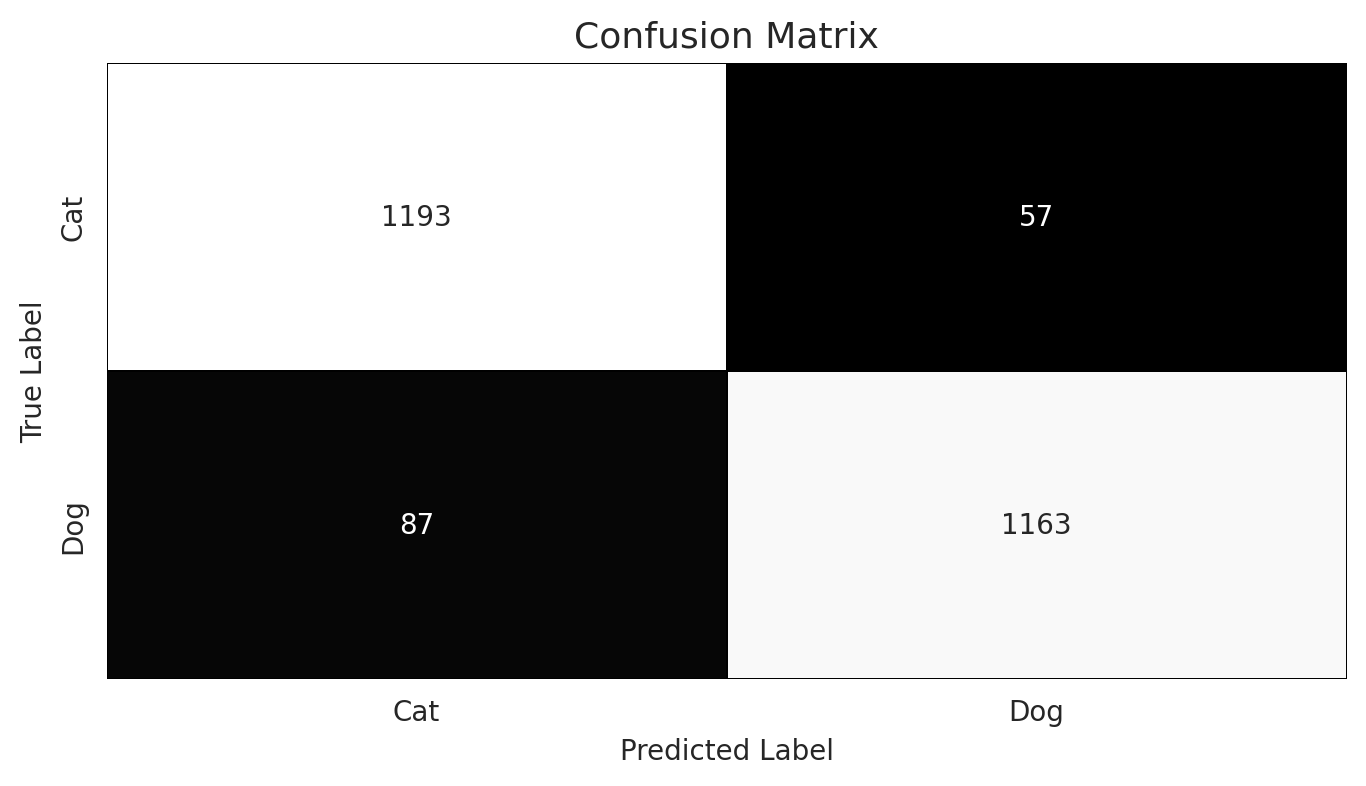

In [24]:
# 13 --------------------------------------------------- Confusion Matrix
# region
# @title 13 - Confusion Matrix { display-mode: "form" }
confusion_mtx = confusion_matrix(y_true,y_pred)
print("Confusion Matrix: \n",confusion_mtx)

f,ax = plt.subplots(figsize = (8,4),dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax,cbar=False, xticklabels=all_entities_names, yticklabels=all_entities_names)

plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix",fontsize=13)

plt.show()
# endregion

